In [1]:
import sys
print(sys.executable)
!pip show tensorflow

c:\Users\daksh\Desktop\DL_proj\venv\Scripts\python.exe
Name: tensorflow
Version: 2.20.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: C:\Users\daksh\Desktop\DL_proj\venv\Lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google_pasta, grpcio, h5py, keras, libclang, ml_dtypes, numpy, opt_einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing_extensions, wrapt
Required-by: 


🔹 Loading dataset...
Data shape: (10459, 8972)
Data shape: (10459, 8972)
Numeric features: 8971
Numeric features: 8971


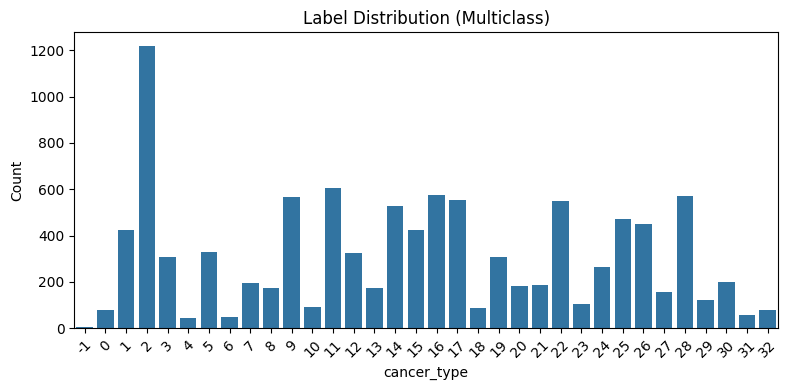

ValueError: Too many bins for data range. Cannot create 50 finite-sized bins.

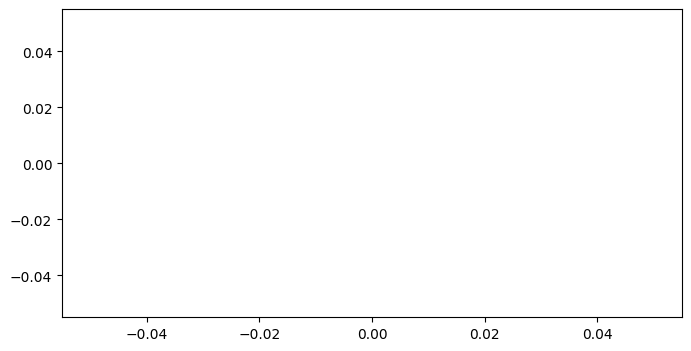

In [ ]:
# multiclass_preprocessing.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA

# ---------------- CONFIG ----------------
SEED = 42
SAMPLE_FRACTION = 1.0
TEST_SIZE = 0.2
VAL_SIZE = 0.1
INPUT_PATH = "Multiclass.csv"
LABEL_COL = "cancer_type"

# ---------------- LOAD + CLEAN ----------------
print("🔹 Loading dataset...")
df = pd.read_csv(INPUT_PATH, low_memory=False)

if SAMPLE_FRACTION < 1.0:
    df = df.sample(frac=SAMPLE_FRACTION, random_state=SEED)

print("Data shape:", df.shape)

if LABEL_COL not in df.columns:
    raise ValueError(f"Label column '{LABEL_COL}' not found in file!")

# Encode labels (convert text to category codes)
y = df[LABEL_COL].astype("category").cat.codes.values
X = df.drop(columns=[LABEL_COL], errors="ignore")
X = X.select_dtypes(include=[np.number])
print("Numeric features:", X.shape[1])

# Handle NaNs
if X.isna().sum().sum() > 0:
    print("Imputing NaNs with column medians...")
    X = X.fillna(X.median())

# ---------------- VISUALIZATIONS ----------------
# Plot class distribution
plt.figure(figsize=(8, 4))
unique_counts = pd.Series(y).value_counts().sort_index()
sns.barplot(x=unique_counts.index, y=unique_counts.values)
plt.title("Label Distribution (Multiclass)")
plt.xlabel(LABEL_COL)
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot feature variances with simpler histogram
feature_variances = X.var(axis=0)
plt.figure(figsize=(8, 4))
plt.hist(feature_variances, bins=20, edgecolor='black')  # Using 20 bins
plt.title("Distribution of Feature Variance")
plt.xlabel("Variance")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Print variance statistics
print("\nFeature Variance Statistics:")
print(f"Min variance: {feature_variances.min():.6f}")
print(f"Max variance: {feature_variances.max():.6f}")
print(f"Mean variance: {feature_variances.mean():.6f}")
print(f"Median variance: {feature_variances.median():.6f}")

# PCA visualization
print("\nRunning PCA for visualization...")
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X.values))
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], y=X_pca[:, 1], c=y, cmap='tab10', alpha=0.6, s=20)
plt.colorbar(scatter, label=LABEL_COL)
plt.title("PCA 2D Projection")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.tight_layout()
plt.show()

# Print PCA explained variance
print(f"\nPCA explained variance ratio: {pca.explained_variance_ratio_.sum():.2%}")

# ---------------- SPLIT DATA ----------------
X_temp, X_test, y_temp, y_test = train_test_split(
    X.values, y, test_size=TEST_SIZE, stratify=y, random_state=SEED
)
val_fraction_of_temp = VAL_SIZE / (1.0 - TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_fraction_of_temp, stratify=y_temp, random_state=SEED
)

print("\nSplit sizes:")
print(f"Train shape: {X_train.shape}")
print(f"Val shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

# ---------------- SCALING + CLASS WEIGHTS ----------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

classes = np.unique(y_train)
cw = compute_class_weight("balanced", classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, cw))
sample_weights = np.array([class_weight_dict[int(lbl)] for lbl in y_train], dtype=float)

print("\nClass distribution:")
for cls, weight in class_weight_dict.items():
    count = (y_train == cls).sum()
    print(f"Class {cls}: {count} samples, weight = {weight:.2f}")

print("\n✅ Preprocessing complete! Ready for SAINT model training.")

In [6]:
# saint_multiclass.py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib

# -------------------------
# Dataset Class
# -------------------------
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# -------------------------
# SAINT Transformer Block
# -------------------------
class SAINTBlock(nn.Module):
    def __init__(self, dim, num_heads, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Linear(dim * 4, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_out, _ = self.self_attn(x, x, x)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)
        ffn_out = self.ffn(x)
        x = x + self.dropout(ffn_out)
        x = self.norm2(x)
        return x


# -------------------------
# SAINT Model
# -------------------------
class SAINT(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=4, num_layers=4, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, 128)
        self.layers = nn.ModuleList(
            [SAINTBlock(128, num_heads, dropout) for _ in range(num_layers)]
        )
        self.fc = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(0)  # (seq_len, batch, dim)
        for layer in self.layers:
            x = layer(x)
        x = x.mean(dim=0)   # mean pooling
        x = self.dropout(x)
        return self.fc(x)


# -------------------------
# Train & Evaluate
# -------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=25, device='cpu'):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


def evaluate_model(model, data_loader, criterion, device='cpu'):
    model.eval()
    total_loss = 0
    preds_list, y_true = [], []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            total_loss += loss.item()
            preds_list.extend(torch.argmax(preds, dim=1).cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())

    acc = accuracy_score(y_true, preds_list)
    return total_loss, acc


# -------------------------
# Main Script
# -------------------------
if __name__ == "__main__":
    # Load dataset
    df = pd.read_csv("multiclass.csv")
    target_col = "cancer_type"

    X = df.drop(columns=[target_col]).values
    y = df[target_col].values

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    num_classes = len(le.classes_)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

    train_ds = TabularDataset(X_train, y_train)
    val_ds = TabularDataset(X_val, y_val)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

    # Model setup
    model = SAINT(input_dim=X.shape[1], num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"✅ Training on {device.upper()}...")

    # Train
    train_model(model, train_loader, val_loader, criterion, optimizer, epochs=25, device=device)

    # Evaluate final performance
    val_loss, val_acc = evaluate_model(model, val_loader, criterion, device=device)
    print(f"\n🎯 Final Validation Accuracy: {val_acc:.4f}\n")

    # Classification report
    model.eval()
    y_pred = []
    with torch.no_grad():
        for X_batch, _ in val_loader:
            preds = model(X_batch.to(device))
            y_pred.extend(torch.argmax(preds, dim=1).cpu().numpy())

    print("📊 Classification Report:")
    print(classification_report(y_val, y_pred, target_names=le.classes_))

    # Save model and scaler
    torch.save(model.state_dict(), "saint_multiclass_model.pth")
    joblib.dump(scaler, "scaler_saint_multi.pkl")
    print("\n✅ Model and scaler saved successfully!")


✅ Training on CPU...
Epoch 1/25 | Train Loss: 133.3036 | Val Loss: 16.1602 | Val Acc: 0.9269
Epoch 2/25 | Train Loss: 59.5095 | Val Loss: 17.0928 | Val Acc: 0.9226
Epoch 3/25 | Train Loss: 48.5469 | Val Loss: 16.4089 | Val Acc: 0.9259
Epoch 4/25 | Train Loss: 36.6156 | Val Loss: 15.6574 | Val Acc: 0.9321
Epoch 5/25 | Train Loss: 33.3068 | Val Loss: 15.3153 | Val Acc: 0.9369
Epoch 6/25 | Train Loss: 29.3102 | Val Loss: 13.2981 | Val Acc: 0.9436
Epoch 7/25 | Train Loss: 29.4032 | Val Loss: 16.4824 | Val Acc: 0.9302
Epoch 8/25 | Train Loss: 25.9375 | Val Loss: 15.9810 | Val Acc: 0.9340
Epoch 9/25 | Train Loss: 27.1570 | Val Loss: 14.2851 | Val Acc: 0.9374
Epoch 10/25 | Train Loss: 18.2124 | Val Loss: 15.8789 | Val Acc: 0.9383
Epoch 11/25 | Train Loss: 16.9321 | Val Loss: 13.8433 | Val Acc: 0.9407
Epoch 12/25 | Train Loss: 22.4790 | Val Loss: 14.3361 | Val Acc: 0.9398
Epoch 13/25 | Train Loss: 16.8071 | Val Loss: 16.2290 | Val Acc: 0.9388
Epoch 14/25 | Train Loss: 18.5709 | Val Loss: 15.31

c:\Users\daksh\Desktop\DL_proj\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


TypeError: object of type 'float' has no len()

📊 Classification Report:
              precision    recall  f1-score   support

    TCGA-ACC       0.94      0.94      0.94        16
   TCGA-BLCA       0.96      0.94      0.95        85
   TCGA-BRCA       0.99      0.99      0.99       244
   TCGA-CESC       0.89      0.93      0.91        61
   TCGA-CHOL       0.83      0.56      0.67         9
   TCGA-COAD       0.78      0.98      0.87        66
   TCGA-DLBC       1.00      1.00      1.00        10
   TCGA-ESCA       0.89      0.85      0.87        39
    TCGA-GBM       1.00      1.00      1.00        34
   TCGA-HNSC       0.99      0.97      0.98       113
   TCGA-KICH       0.81      0.94      0.87        18
   TCGA-KIRC       0.97      0.92      0.94       121
   TCGA-KIRP       0.90      0.94      0.92        65
   TCGA-LAML       1.00      1.00      1.00        35
    TCGA-LGG       1.00      1.00      1.00       106
   TCGA-LIHC       0.93      0.96      0.95        85
   TCGA-LUAD       0.93      0.97      0.94       115
  

c:\Users\daksh\Desktop\DL_proj\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\daksh\Desktop\DL_proj\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\daksh\Desktop\DL_proj\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

<Figure size 700x600 with 0 Axes>

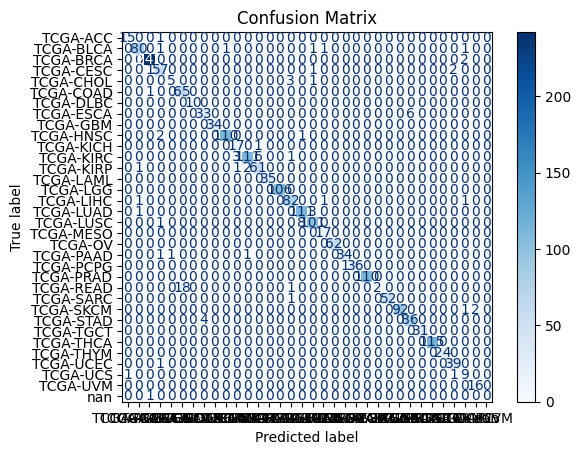

In [9]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert validation data to tensor
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

model.eval()
y_pred = []

with torch.no_grad():
    for x_batch in X_val_tensor:
        preds = model(x_batch.to(device).unsqueeze(0))
        y_pred.append(torch.argmax(preds, dim=1).cpu().item())

y_pred = np.array(y_pred)

# Ensure labels are integers and get unique labels
unique_labels = np.unique(np.concatenate([y_val, y_pred])).astype(int)

# Convert numeric labels back to original class names
target_names = [str(name) for name in le.inverse_transform(unique_labels)]

print("📊 Classification Report:")
print(classification_report(y_val, y_pred, labels=unique_labels, target_names=target_names))

# 🧩 Confusion Matrix
cm = confusion_matrix(y_val, y_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
plt.figure(figsize=(7, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

Epoch 1/25 | Train Loss: 0.0405 | Val Loss: 0.2202
Epoch 2/25 | Train Loss: 0.0498 | Val Loss: 0.2770
Epoch 2/25 | Train Loss: 0.0498 | Val Loss: 0.2770
Epoch 3/25 | Train Loss: 0.0457 | Val Loss: 0.3190
Epoch 3/25 | Train Loss: 0.0457 | Val Loss: 0.3190
Epoch 4/25 | Train Loss: 0.0393 | Val Loss: 0.3362
Epoch 4/25 | Train Loss: 0.0393 | Val Loss: 0.3362
Epoch 5/25 | Train Loss: 0.0621 | Val Loss: 0.2853
Epoch 5/25 | Train Loss: 0.0621 | Val Loss: 0.2853
Epoch 6/25 | Train Loss: 0.0415 | Val Loss: 0.2448
Epoch 6/25 | Train Loss: 0.0415 | Val Loss: 0.2448
Epoch 7/25 | Train Loss: 0.0438 | Val Loss: 0.2201
Epoch 7/25 | Train Loss: 0.0438 | Val Loss: 0.2201
Epoch 8/25 | Train Loss: 0.0389 | Val Loss: 0.2227
Epoch 8/25 | Train Loss: 0.0389 | Val Loss: 0.2227
Epoch 9/25 | Train Loss: 0.0354 | Val Loss: 0.3252
Epoch 9/25 | Train Loss: 0.0354 | Val Loss: 0.3252
Epoch 10/25 | Train Loss: 0.0343 | Val Loss: 0.2200
Epoch 10/25 | Train Loss: 0.0343 | Val Loss: 0.2200
Epoch 11/25 | Train Loss: 0.0

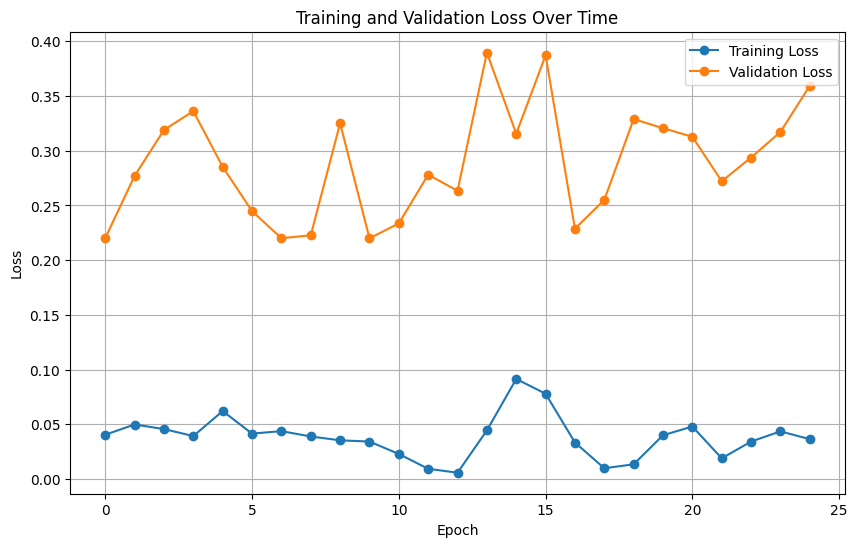

⚠️ Model may be overfitting — validation loss is much higher than training loss


: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store losses
losses = {
    'train': [],
    'val': []
}

# Training loop with loss tracking
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

for epoch in range(25):  # 25 epochs
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Store training loss
    avg_train_loss = total_loss / len(train_loader)
    losses['train'].append(avg_train_loss)
    
    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    losses['val'].append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/25 | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(losses['train'], label='Training Loss', marker='o')
plt.plot(losses['val'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Interpret the results
final_train_loss = losses['train'][-1]
final_val_loss = losses['val'][-1]

if final_val_loss > final_train_loss * 1.3:
    print("⚠️ Model may be overfitting — validation loss is much higher than training loss")
elif final_val_loss > final_train_loss:
    print("⚠️ Slight overfitting detected")
else:
    print("✅ Model seems well-generalized")